流体数据处理工具 - 湍流分析
功能: 雷诺分解, 湍流强度计算, 能谱分析, -5/3定律验证
湍流分析工具使用示例

1. 使用模拟数据进行测试...
模拟数据已保存到: sample_turbulence_data.csv
数据加载成功: sample_turbulence_data.csv
数据形状: (5000, 5)
数据列名: ['time', 'u_velocity', 'v_velocity', 'w_velocity', 'pressure']
发现时间列: time

2. 执行雷诺分解...
雷诺分解完成 - 方法: time_average
平均速度: 10.3183
脉动速度标准差: 1.4917
脉动速度最大值: 5.0640
脉动速度最小值: -4.0351

3. 计算湍流强度...
雷诺分解完成 - 方法: time_average
平均速度: 10.3183
脉动速度标准差: 1.4917
脉动速度最大值: 5.0640
脉动速度最小值: -4.0351
雷诺分解完成 - 方法: time_average
平均速度: -0.0092
脉动速度标准差: 0.5098
脉动速度最大值: 1.7737
脉动速度最小值: -1.9091
雷诺分解完成 - 方法: time_average
平均速度: 0.0007
脉动速度标准差: 0.2965
脉动速度最大值: 1.0280
脉动速度最小值: -1.1774

湍流强度计算结果:

分量: u_velocity
  平均速度: 10.3183
  RMS速度: 1.4917
  湍流强度: 14.4569%
  偏度: 0.0051
  峰度: -0.3105

分量: v_velocity
  平均速度: -0.0092
  RMS速度: 0.5098
  湍流强度: 5531.7284%
  偏度: 0.0063
  峰度: 0.0615

分量: w_velocity
  平均速度: 0.0007
  RMS速度: 0.2965
  湍流强度: 42042.1349%
  偏度: -0.0294
  峰度: 0.0386

4. 计算能谱...

5. 拟合-5/3标度律...

6. 生成可视化结果...


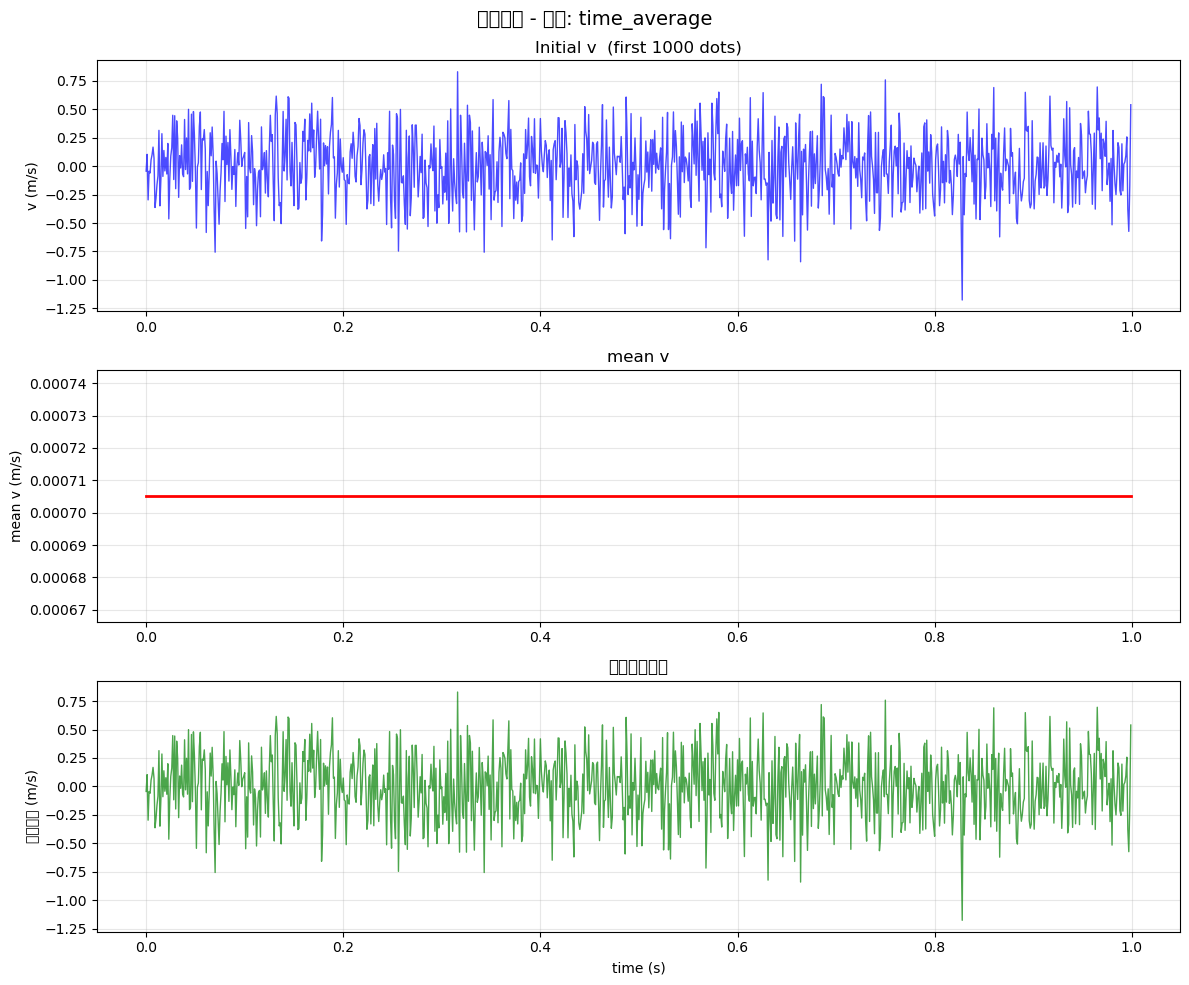

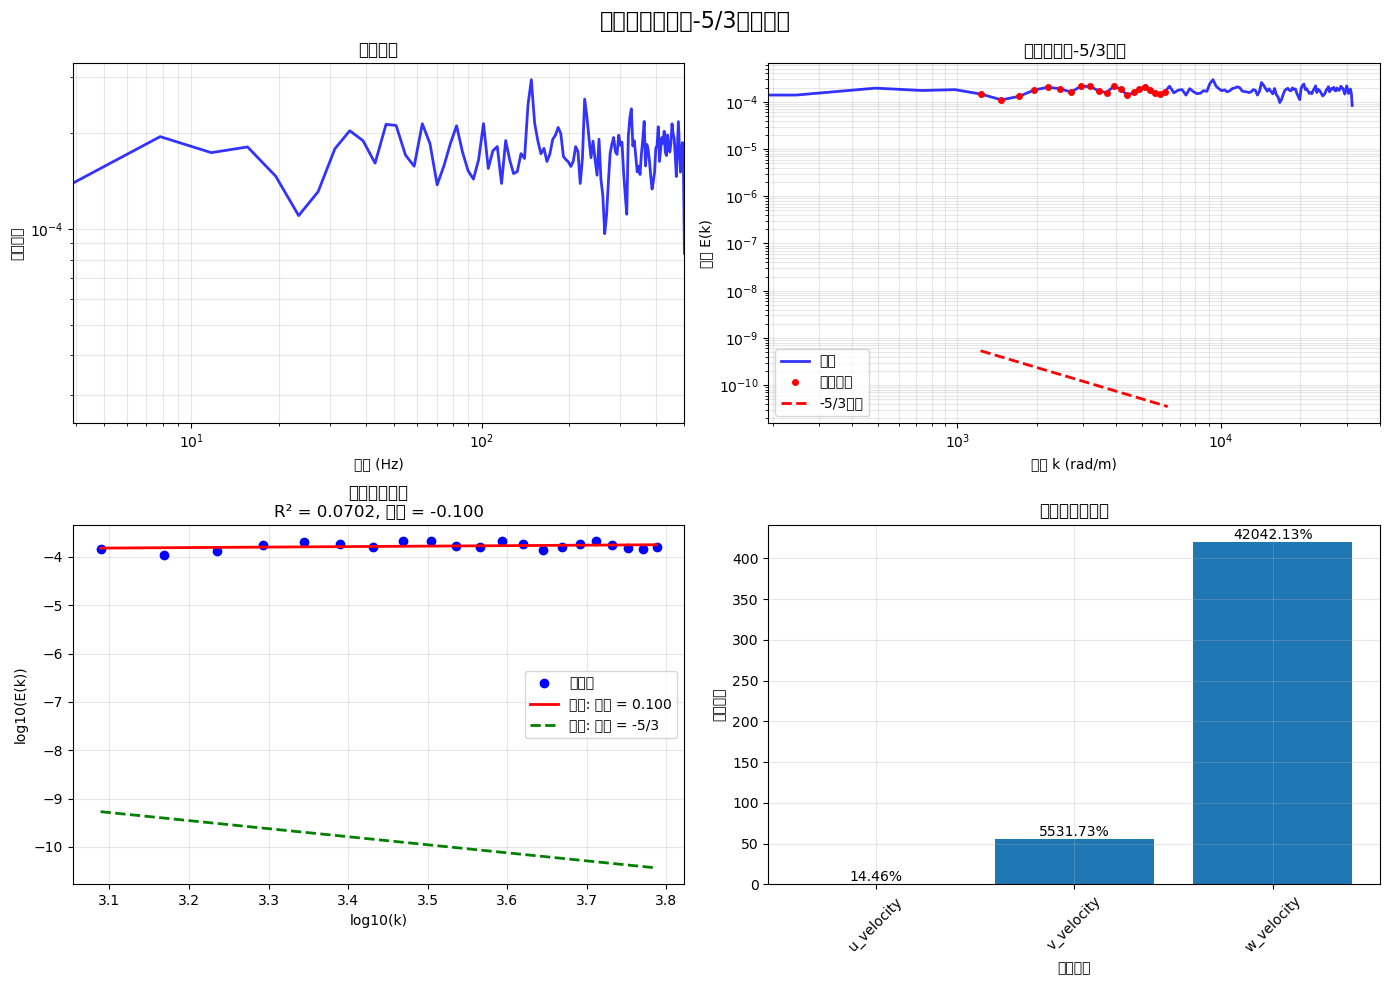

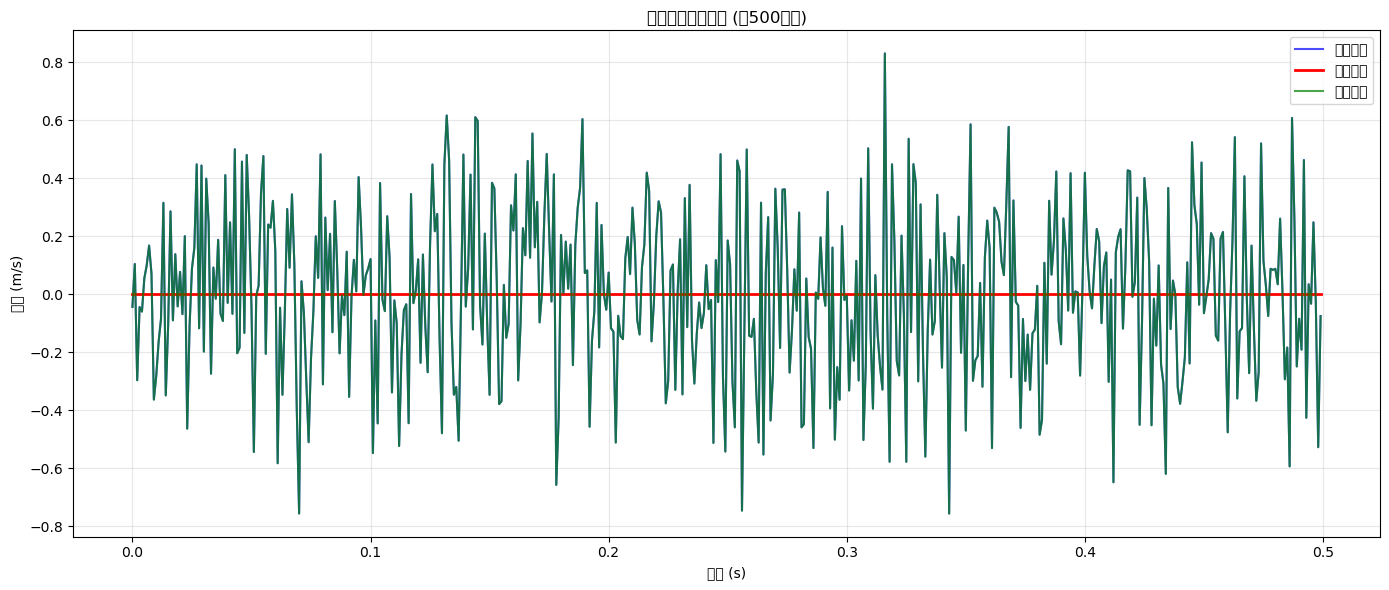

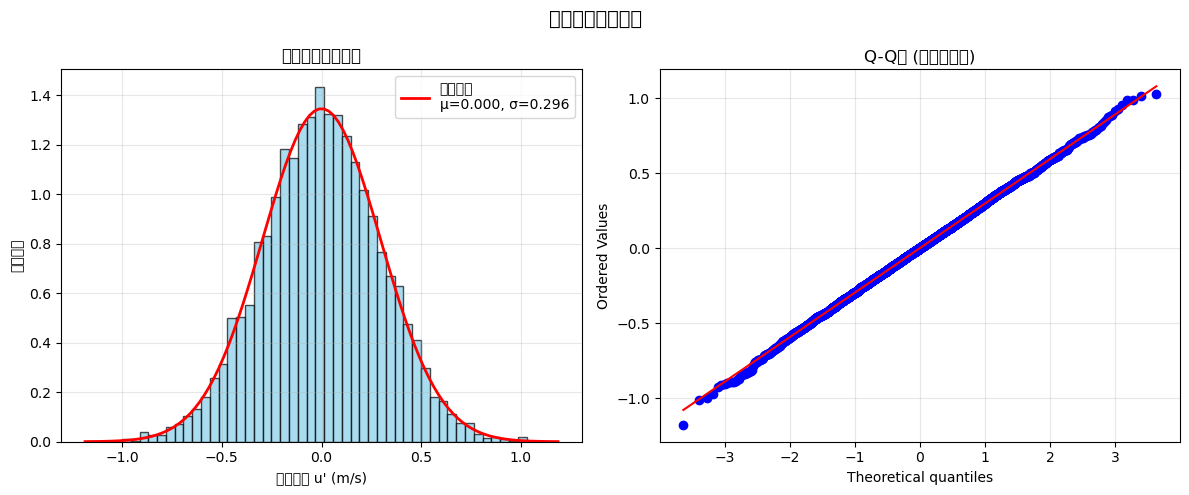


7. 生成分析报告...

生成湍流分析报告
统计结果保存至: ./turbulence_analysis_results\turbulence_statistics.csv
能谱数据保存至: ./turbulence_analysis_results\energy_spectrum.csv
雷诺分解数据保存至: ./turbulence_analysis_results\reynolds_decomposition.csv
图像保存至: ./turbulence_analysis_results\reynolds_decomposition.png


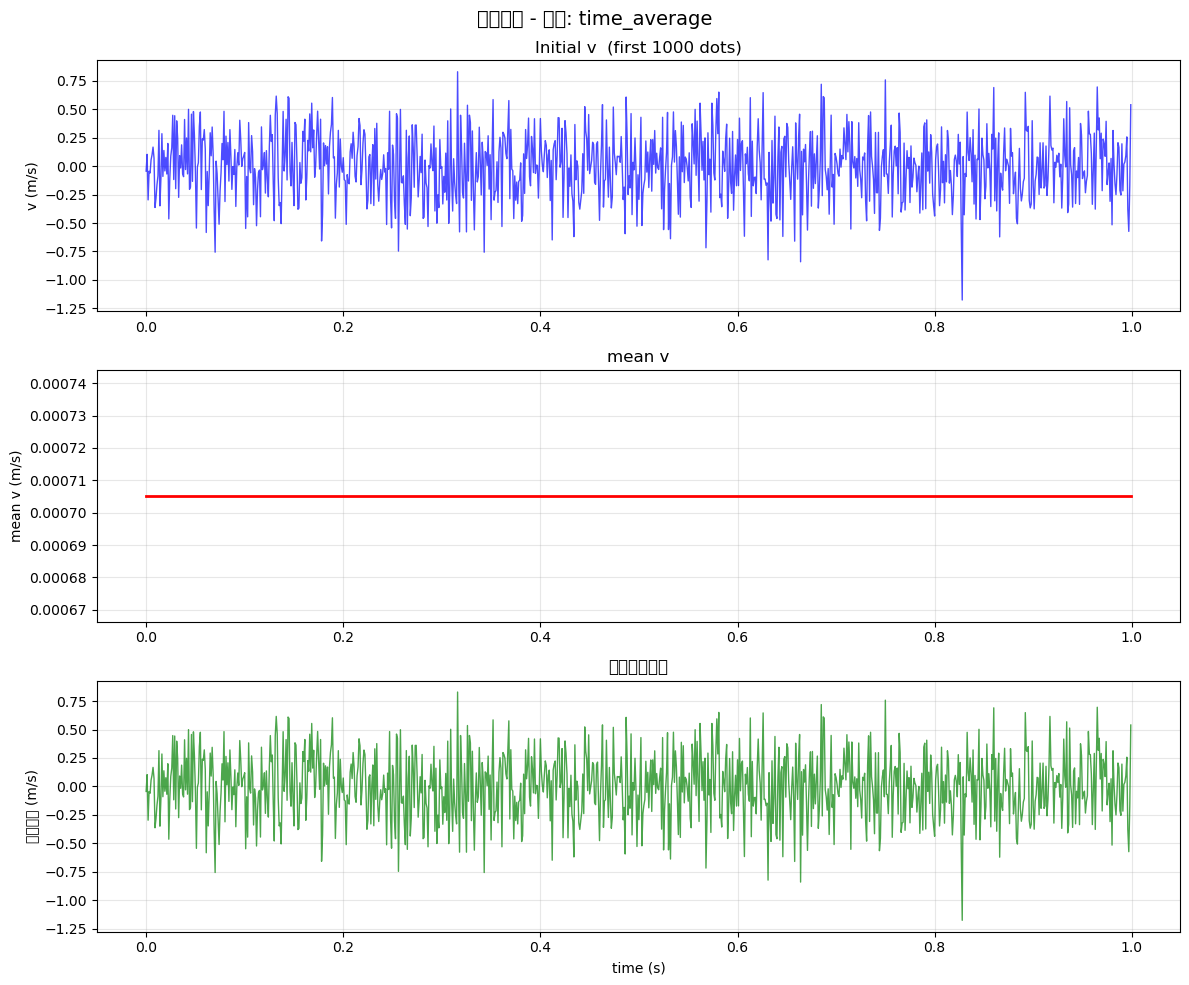

图像保存至: ./turbulence_analysis_results\energy_spectrum_analysis.png


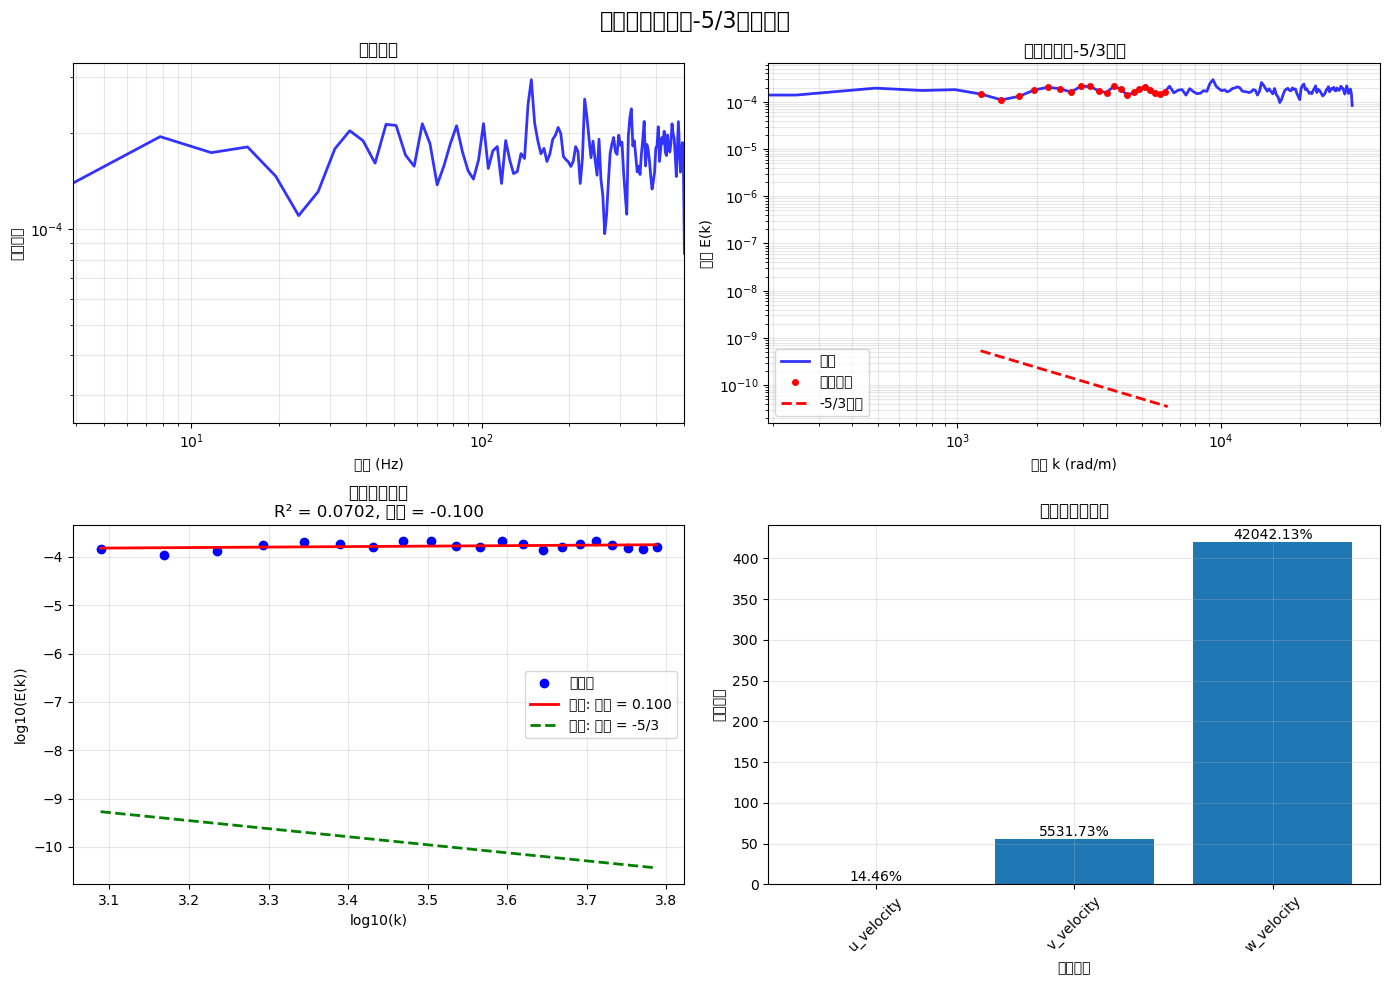

图像保存至: ./turbulence_analysis_results\time_series_comparison.png


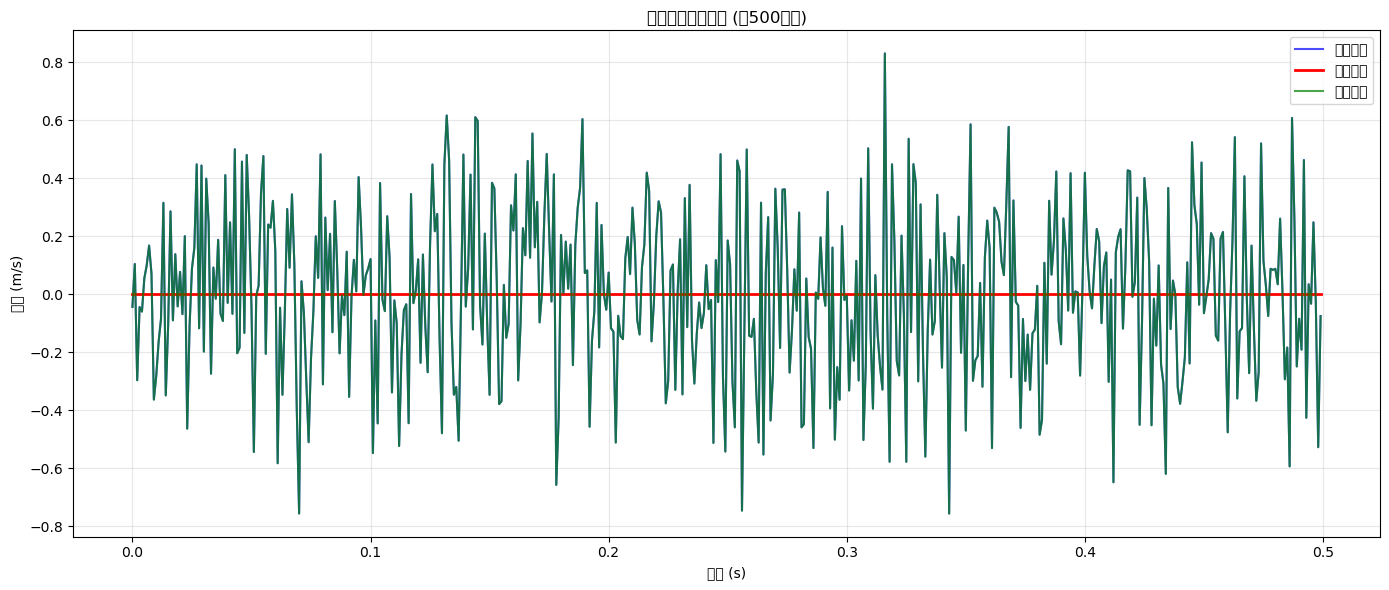

图像保存至: ./turbulence_analysis_results\statistical_distribution.png


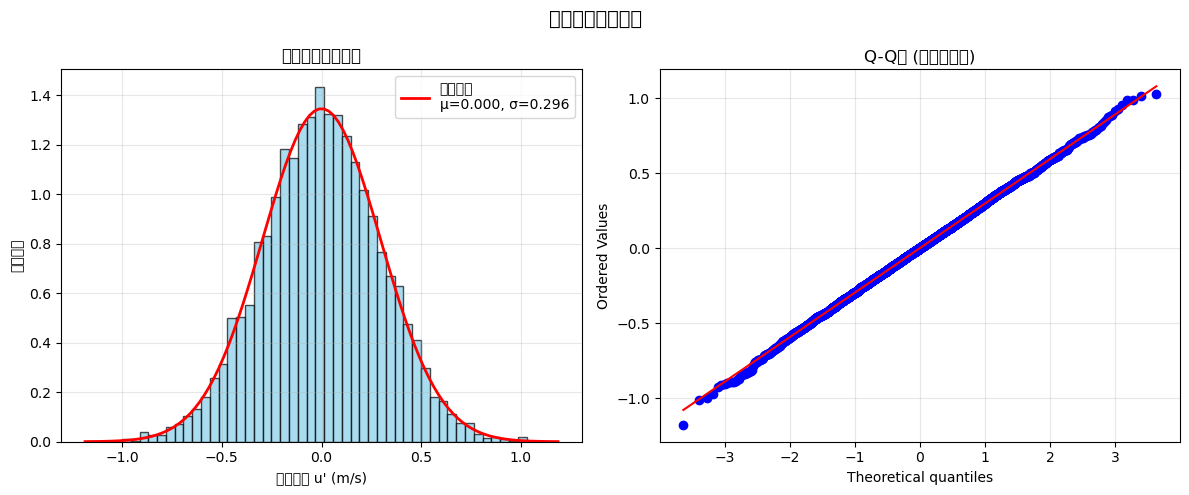

分析报告保存至: ./turbulence_analysis_results\analysis_report.txt
所有输出文件保存至: ./turbulence_analysis_results

示例完成！


In [3]:
"""
流体数据处理工具 - 湍流分析工具箱
功能：雷诺分解、湍流强度计算、能谱分析、-5/3定律验证
作者：流体力学数据分析助手
日期：2024年
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, fft, stats, interpolate
from scipy.signal import welch
import os
from pathlib import Path
from typing import Tuple, Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

class TurbulenceAnalyzer:
    """
    湍流数据分析器类
    实现雷诺分解、湍流统计、能谱分析等功能
    """
    
    def __init__(self, data_path: str = None, sample_rate: float = 1000.0):
        """
        初始化湍流分析器
        
        参数:
        ----------
        data_path : str, optional
            CSV数据文件路径
        sample_rate : float
            采样频率 (Hz)
        """
        self.data = None
        self.sample_rate = sample_rate
        self.time_step = 1.0 / sample_rate
        self.decomposed_data = {}
        self.statistics = {}
        self.spectra = {}
        
        if data_path:
            self.load_data(data_path)
    
    def load_data(self, file_path: str) -> pd.DataFrame:
        """
        加载CSV格式的流体数据
        
        参数:
        ----------
        file_path : str
            CSV文件路径
            
        返回:
        ----------
        pd.DataFrame
            加载的数据
        """
        try:
            self.data = pd.read_csv(file_path)
            print(f"数据加载成功: {file_path}")
            print(f"数据形状: {self.data.shape}")
            print(f"数据列名: {list(self.data.columns)}")
            
            # 自动检测时间列
            time_cols = ['t', 'time', 'Time', 'TIME', 't(s)', 't_sec']
            for col in time_cols:
                if col in self.data.columns:
                    print(f"发现时间列: {col}")
                    break
            
            return self.data
            
        except Exception as e:
            print(f"加载数据失败: {e}")
            raise
    
    def reynolds_decomposition(self, velocity_column: str, 
                               method: str = 'time_average') -> Dict[str, np.ndarray]:
        """
        执行雷诺分解: u = ū + u'
        
        参数:
        ----------
        velocity_column : str
            速度数据列名
        method : str
            平均方法: 'time_average' (时间平均), 
                     'moving_average' (移动平均),
                     'ensemble_average' (系综平均，如果有多组数据)
            
        返回:
        ----------
        dict
            包含平均速度、脉动速度、原始速度的字典
        """
        if velocity_column not in self.data.columns:
            raise ValueError(f"列 '{velocity_column}' 不存在于数据中")
        
        u = self.data[velocity_column].values
        
        if method == 'time_average':
            # 时间平均 - 得到一个标量
            u_mean = np.mean(u)
            # 创建一个与原始数据相同长度的数组
            u_mean_array = np.full_like(u, u_mean)
            
        elif method == 'moving_average':
            # 移动平均（低通滤波）
            window_size = min(100, len(u) // 10)
            if window_size % 2 == 0:
                window_size += 1
            u_mean_array = np.convolve(u, np.ones(window_size)/window_size, mode='same')
            
        elif method == 'ensemble_average':
            # 系综平均（假设有多个实现）
            # 这里简化为分段平均
            n_segments = 10
            segment_length = len(u) // n_segments
            u_mean_array = np.zeros_like(u)
            
            for i in range(n_segments):
                start_idx = i * segment_length
                end_idx = start_idx + segment_length
                if i == n_segments - 1:
                    end_idx = len(u)
                segment_mean = np.mean(u[start_idx:end_idx])
                u_mean_array[start_idx:end_idx] = segment_mean
        else:
            raise ValueError(f"未知的平均方法: {method}")
        
        # 计算脉动速度
        u_prime = u - u_mean_array
        
        # 存储结果
        self.decomposed_data = {
            'u_raw': u,
            'u_mean': u_mean_array,  # 现在始终是数组
            'u_mean_scalar': np.mean(u_mean_array),  # 存储标量平均值
            'u_prime': u_prime,
            'method': method
        }
        
        print(f"雷诺分解完成 - 方法: {method}")
        print(f"平均速度: {np.mean(u_mean_array):.4f}")
        print(f"脉动速度标准差: {np.std(u_prime):.4f}")
        print(f"脉动速度最大值: {np.max(u_prime):.4f}")
        print(f"脉动速度最小值: {np.min(u_prime):.4f}")
        
        return self.decomposed_data
    
    def calculate_turbulence_intensity(self, velocity_columns: List[str] = None) -> Dict:
        """
        计算湍流强度
        
        参数:
        ----------
        velocity_columns : List[str], optional
            速度列名列表，如果为None则自动查找u,v,w列
            
        返回:
        ----------
        dict
            湍流强度统计量
        """
        if not self.decomposed_data:
            print("警告: 先执行雷诺分解")
            # 如果没有分解数据，尝试使用原始数据计算
            if velocity_columns is None:
                velocity_columns = []
                for col in ['u', 'v', 'w', 'U', 'V', 'W', 'u_vel', 'v_vel', 'w_vel']:
                    if col in self.data.columns:
                        velocity_columns.append(col)
            
            if not velocity_columns:
                numeric_cols = self.data.select_dtypes(include=[np.number]).columns
                if len(numeric_cols) > 0:
                    velocity_columns = [numeric_cols[0]]
                else:
                    raise ValueError("未找到速度数据列")
        
        turbulence_stats = {}
        
        for col in velocity_columns:
            if col in self.data.columns:
                # 对该分量执行雷诺分解
                decomp = self.reynolds_decomposition(col, method='time_average')
                u_mean_scalar = decomp['u_mean_scalar']
                u_prime = decomp['u_prime']
                
                # 计算湍流强度
                u_rms = np.sqrt(np.mean(u_prime**2))
                
                # 湍流强度定义
                TI = u_rms / abs(u_mean_scalar) if abs(u_mean_scalar) > 1e-10 else 0
                
                # 存储统计量
                turbulence_stats[col] = {
                    'mean_velocity': u_mean_scalar,
                    'rms_velocity': u_rms,
                    'turbulence_intensity': TI,
                    'skewness': stats.skew(u_prime),
                    'kurtosis': stats.kurtosis(u_prime),
                    'variance': np.var(u_prime),
                    'max_fluctuation': np.max(np.abs(u_prime))
                }
        
        self.statistics['turbulence_intensity'] = turbulence_stats
        
        # 打印结果
        print("\n" + "="*60)
        print("湍流强度计算结果:")
        print("="*60)
        for col, stats_dict in turbulence_stats.items():
            print(f"\n分量: {col}")
            print(f"  平均速度: {stats_dict['mean_velocity']:.4f}")
            print(f"  RMS速度: {stats_dict['rms_velocity']:.4f}")
            print(f"  湍流强度: {stats_dict['turbulence_intensity']:.4%}")
            print(f"  偏度: {stats_dict['skewness']:.4f}")
            print(f"  峰度: {stats_dict['kurtosis']:.4f}")
        
        return turbulence_stats
    
    def calculate_energy_spectrum(self, signal_data: np.ndarray = None, 
                                 window_type: str = 'hann',
                                 nperseg: int = None,
                                 scaling: str = 'density') -> Tuple[np.ndarray, np.ndarray]:
        """
        计算能谱密度（PSD）
        
        参数:
        ----------
        signal_data : np.ndarray, optional
            输入信号，如果为None则使用分解后的脉动速度
        window_type : str
            窗函数类型
        nperseg : int, optional
            每个段的长度
        scaling : str
            缩放方式: 'density' 或 'spectrum'
            
        返回:
        ----------
        Tuple[np.ndarray, np.ndarray]
            频率数组和能谱数组
        """
        if signal_data is None:
            if 'u_prime' not in self.decomposed_data:
                raise ValueError("请先执行雷诺分解")
            signal_data = self.decomposed_data['u_prime']
        
        # 设置分段长度
        if nperseg is None:
            nperseg = min(256, len(signal_data) // 8)
            nperseg = 2 ** int(np.log2(nperseg))  # 转换为2的幂
        
        # 计算Welch谱
        frequencies, power_spectrum = welch(
            signal_data,
            fs=self.sample_rate,
            window=window_type,
            nperseg=nperseg,
            noverlap=nperseg // 2,
            scaling=scaling,
            detrend='linear'
        )
        
        # 存储结果
        self.spectra['frequencies'] = frequencies
        self.spectra['power_spectrum'] = power_spectrum
        self.spectra['nperseg'] = nperseg
        
        return frequencies, power_spectrum
    
    def fit_kolmogorov_scaling(self, frequencies: np.ndarray, 
                              spectrum: np.ndarray,
                              fit_range: Tuple[float, float] = None) -> Dict:
        """
        拟合Kolmogorov -5/3标度律
        
        参数:
        ----------
        frequencies : np.ndarray
            频率数组
        spectrum : np.ndarray
            能谱数组
        fit_range : Tuple[float, float], optional
            拟合的频率范围 (Hz)
            
        返回:
        ----------
        dict
            拟合结果
        """
        # 转换为波数（假设Taylor冻结假设）
        U_mean = self.decomposed_data.get('u_mean_scalar', 1.0)
        
        # 波数: k = 2πf/U
        k = 2 * np.pi * frequencies / max(U_mean, 0.1)
        
        # 选择惯性子区范围
        if fit_range is None:
            # 自动选择范围：排除低频和高频部分
            k_min = k[1] * 5  # 跳过前几个点
            k_max = k[-1] / 5  # 排除最高频部分
        else:
            k_min, k_max = fit_range
        
        # 选择惯性子区数据点
        inertial_indices = np.where((k >= k_min) & (k <= k_max))[0]
        
        if len(inertial_indices) < 10:
            print("警告: 惯性子区数据点不足，使用所有数据点")
            inertial_indices = np.arange(1, len(k)-5)  # 跳过第一个和最后几个点
        
        k_inertial = k[inertial_indices]
        E_inertial = spectrum[inertial_indices]
        
        # 对数和线性拟合
        log_k = np.log10(k_inertial)
        log_E = np.log10(E_inertial)
        
        # 线性拟合：log10(E) = C - (5/3)*log10(k)
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_E)
        
        # 计算拟合的-5/3指数
        fitted_exponent = -slope
        kolmogorov_exponent = 5/3
        
        # 计算拟合优度
        residuals = log_E - (intercept + slope * log_k)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((log_E - np.mean(log_E))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # 计算95%置信区间
        n = len(log_k)
        if n > 2:
            t_val = stats.t.ppf(0.975, n-2)  # 95%置信水平
            slope_err = std_err
            slope_ci = (slope - t_val * slope_err, slope + t_val * slope_err)
        else:
            slope_ci = (slope, slope)
        
        # 预测的-5/3线
        k_fit = np.logspace(np.log10(k_min), np.log10(k_max), 100)
        E_fit_theory = 10**intercept * k_fit**(-kolmogorov_exponent)
        E_fit_actual = 10**intercept * k_fit**(slope)
        
        results = {
            'wave_numbers': k,
            'spectrum': spectrum,
            'inertial_indices': inertial_indices,
            'fitted_slope': slope,
            'fitted_intercept': intercept,
            'fitted_exponent': fitted_exponent,
            'kolmogorov_exponent': kolmogorov_exponent,
            'r_squared': r_squared,
            'r_value': r_value,
            'slope_confidence_interval': slope_ci,
            'exponent_error': abs(fitted_exponent - kolmogorov_exponent),
            'fit_wave_numbers': k_fit,
            'fit_spectrum_theory': E_fit_theory,
            'fit_spectrum_actual': E_fit_actual
        }
        
        self.spectra['kolmogorov_fit'] = results
        
        return results
    
    def plot_reynolds_decomposition(self, save_path: str = None):
        """
        绘制雷诺分解结果
        
        参数:
        ----------
        save_path : str, optional
            保存图像路径
        """
        if not self.decomposed_data:
            print("请先执行雷诺分解")
            return
        
        fig, axes = plt.subplots(3, 1, figsize=(12, 10))
        
        # 原始数据
        time = np.arange(len(self.decomposed_data['u_raw'])) * self.time_step
        
        # 只显示前1000个点以便更清晰
        display_points = min(1000, len(time))
        
        ax1 = axes[0]
        ax1.plot(time[:display_points], self.decomposed_data['u_raw'][:display_points], 
                'b-', alpha=0.7, linewidth=1)
        ax1.set_ylabel('v (m/s)')
        ax1.set_title('Initial v  (first 1000 dots)')
        ax1.grid(True, alpha=0.3)
        
        # 平均速度
        ax2 = axes[1]
        u_mean = self.decomposed_data['u_mean']
        ax2.plot(time[:display_points], u_mean[:display_points], 'r-', linewidth=2)
        ax2.set_ylabel('mean v (m/s)')
        ax2.set_title('mean v')
        ax2.grid(True, alpha=0.3)
        
        # 脉动速度
        ax3 = axes[2]
        u_prime = self.decomposed_data['u_prime']
        ax3.plot(time[:display_points], u_prime[:display_points], 'g-', alpha=0.7, linewidth=1)
        ax3.set_xlabel('time (s)')
        ax3.set_ylabel('脉动速度 (m/s)')
        ax3.set_title('脉动速度分量')
        ax3.grid(True, alpha=0.3)
        
        plt.suptitle(f'雷诺分解 - 方法: {self.decomposed_data["method"]}', fontsize=14)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图像保存至: {save_path}")
        
        plt.show()
    
    def plot_energy_spectrum(self, save_path: str = None):
        """
        绘制能谱和-5/3定律验证
        
        参数:
        ----------
        save_path : str, optional
            保存图像路径
        """
        if 'frequencies' not in self.spectra:
            print("请先计算能谱")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. 能谱图（线性坐标）
        ax1 = axes[0, 0]
        frequencies = self.spectra['frequencies']
        spectrum = self.spectra['power_spectrum']
        
        ax1.loglog(frequencies, spectrum, 'b-', linewidth=2, alpha=0.8)
        ax1.set_xlabel('频率 (Hz)')
        ax1.set_ylabel('能谱密度')
        ax1.set_title('湍流能谱')
        ax1.grid(True, which='both', alpha=0.3)
        ax1.set_xlim([frequencies[1], frequencies[-1]])
        
        # 2. 能谱图（波数坐标）
        ax2 = axes[0, 1]
        if 'kolmogorov_fit' in self.spectra:
            results = self.spectra['kolmogorov_fit']
            k = results['wave_numbers']
            
            ax2.loglog(k, spectrum, 'b-', linewidth=2, alpha=0.8, label='数据')
            
            # 绘制惯性子区范围
            inertial_idx = results['inertial_indices']
            if len(inertial_idx) > 0:
                ax2.loglog(k[inertial_idx], spectrum[inertial_idx], 'ro', 
                          markersize=4, label='惯性子区')
            
            # 绘制-5/3参考线
            k_fit = results['fit_wave_numbers']
            E_fit = results['fit_spectrum_theory']
            ax2.loglog(k_fit, E_fit, 'r--', linewidth=2, label='-5/3斜率')
            
            ax2.legend()
            ax2.set_xlabel('波数 k (rad/m)')
            ax2.set_ylabel('能谱 E(k)')
            ax2.set_title('波数能谱与-5/3定律')
            ax2.grid(True, which='both', alpha=0.3)
        
        # 3. 拟合结果
        ax3 = axes[1, 0]
        if 'kolmogorov_fit' in self.spectra:
            results = self.spectra['kolmogorov_fit']
            
            k_inertial = results['wave_numbers'][results['inertial_indices']]
            E_inertial = results['spectrum'][results['inertial_indices']]
            
            log_k = np.log10(k_inertial)
            log_E = np.log10(E_inertial)
            
            ax3.plot(log_k, log_E, 'bo', markersize=6, label='数据点')
            
            # 绘制拟合线
            x_fit = np.linspace(log_k.min(), log_k.max(), 100)
            y_fit = results['fitted_intercept'] + results['fitted_slope'] * x_fit
            
            ax3.plot(x_fit, y_fit, 'r-', linewidth=2, 
                    label=f'拟合: 斜率 = {results["fitted_slope"]:.3f}')
            
            # 绘制-5/3参考线
            y_theory = results['fitted_intercept'] - (5/3) * x_fit
            ax3.plot(x_fit, y_theory, 'g--', linewidth=2, 
                    label='理论: 斜率 = -5/3')
            
            ax3.set_xlabel('log10(k)')
            ax3.set_ylabel('log10(E(k))')
            ax3.set_title(f'惯性子区拟合\nR² = {results["r_squared"]:.4f}, 指数 = {results["fitted_exponent"]:.3f}')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # 4. 湍流强度分布
        ax4 = axes[1, 1]
        if 'turbulence_intensity' in self.statistics:
            stats_dict = self.statistics['turbulence_intensity']
            
            components = list(stats_dict.keys())
            TI_values = [stats_dict[comp]['turbulence_intensity'] for comp in components]
            
            bars = ax4.bar(range(len(components)), TI_values)
            ax4.set_xlabel('速度分量')
            ax4.set_ylabel('湍流强度')
            ax4.set_title('各分量湍流强度')
            ax4.set_xticks(range(len(components)))
            ax4.set_xticklabels(components, rotation=45)
            ax4.grid(True, alpha=0.3)
            
            # 在柱状图上添加数值
            for i, v in enumerate(TI_values):
                ax4.text(i, v + 0.001, f'{v:.2%}', 
                        ha='center', va='bottom')
        
        plt.suptitle('湍流能谱分析与-5/3定律验证', fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图像保存至: {save_path}")
        
        plt.show()
    
    def plot_time_series_comparison(self, save_path: str = None):
        """
        绘制时间序列对比图
        
        参数:
        ----------
        save_path : str, optional
            保存图像路径
        """
        if not self.decomposed_data:
            print("请先执行雷诺分解")
            return
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        time = np.arange(len(self.decomposed_data['u_raw'])) * self.time_step
        
        # 只显示前500个点以便清晰
        display_points = min(500, len(time))
        
        ax.plot(time[:display_points], self.decomposed_data['u_raw'][:display_points], 
               'b-', alpha=0.7, linewidth=1.5, label='原始速度')
        ax.plot(time[:display_points], self.decomposed_data['u_mean'][:display_points], 
               'r-', linewidth=2, label='平均速度')
        ax.plot(time[:display_points], self.decomposed_data['u_prime'][:display_points], 
               'g-', alpha=0.7, linewidth=1.5, label='脉动速度')
        
        ax.set_xlabel('时间 (s)')
        ax.set_ylabel('速度 (m/s)')
        ax.set_title('雷诺分解结果对比 (前500个点)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图像保存至: {save_path}")
        
        plt.show()
    
    def plot_statistical_distribution(self, save_path: str = None):
        """
        绘制统计分布图
        
        参数:
        ----------
        save_path : str, optional
            保存图像路径
        """
        if not self.decomposed_data:
            print("请先执行雷诺分解")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        u_prime = self.decomposed_data['u_prime']
        
        # 1. 概率密度函数
        ax1 = axes[0]
        ax1.hist(u_prime, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
        
        # 添加高斯分布拟合
        mu, sigma = np.mean(u_prime), np.std(u_prime)
        x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
        pdf = stats.norm.pdf(x, mu, sigma)
        ax1.plot(x, pdf, 'r-', linewidth=2, label=f'高斯分布\nμ={mu:.3f}, σ={sigma:.3f}')
        
        ax1.set_xlabel('脉动速度 u\' (m/s)')
        ax1.set_ylabel('概率密度')
        ax1.set_title('脉动速度概率分布')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Q-Q图
        ax2 = axes[1]
        stats.probplot(u_prime, dist="norm", plot=ax2)
        ax2.set_title('Q-Q图 (检验正态性)')
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle('脉动速度统计分布', fontsize=14)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图像保存至: {save_path}")
        
        plt.show()
    
    def generate_report(self, output_dir: str = './turbulence_analysis_report'):
        """
        生成完整分析报告
        
        参数:
        ----------
        output_dir : str
            输出目录路径
        """
        # 创建输出目录
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        
        print(f"\n{'='*60}")
        print("生成湍流分析报告")
        print(f"{'='*60}")
        
        # 保存统计结果到CSV
        if self.statistics:
            stats_df = pd.DataFrame()
            for comp, stats in self.statistics.get('turbulence_intensity', {}).items():
                stats_df[comp] = pd.Series(stats)
            
            stats_path = os.path.join(output_dir, 'turbulence_statistics.csv')
            stats_df.to_csv(stats_path)
            print(f"统计结果保存至: {stats_path}")
        
        # 保存能谱数据
        if self.spectra:
            spectra_df = pd.DataFrame({
                'frequency_Hz': self.spectra.get('frequencies', []),
                'power_spectrum': self.spectra.get('power_spectrum', []),
            })
            
            spectra_path = os.path.join(output_dir, 'energy_spectrum.csv')
            spectra_df.to_csv(spectra_path, index=False)
            print(f"能谱数据保存至: {spectra_path}")
        
        # 保存分解数据
        if self.decomposed_data:
            decomp_df = pd.DataFrame({
                'u_raw': self.decomposed_data.get('u_raw', []),
                'u_mean': self.decomposed_data.get('u_mean', []),
                'u_prime': self.decomposed_data.get('u_prime', []),
            })
            
            decomp_path = os.path.join(output_dir, 'reynolds_decomposition.csv')
            decomp_df.to_csv(decomp_path, index=False)
            print(f"雷诺分解数据保存至: {decomp_path}")
        
        # 生成图像
        decomp_plot_path = os.path.join(output_dir, 'reynolds_decomposition.png')
        self.plot_reynolds_decomposition(decomp_plot_path)
        
        spectrum_plot_path = os.path.join(output_dir, 'energy_spectrum_analysis.png')
        self.plot_energy_spectrum(spectrum_plot_path)
        
        time_series_path = os.path.join(output_dir, 'time_series_comparison.png')
        self.plot_time_series_comparison(time_series_path)
        
        distribution_path = os.path.join(output_dir, 'statistical_distribution.png')
        self.plot_statistical_distribution(distribution_path)
        
        # 生成文本报告
        report_path = os.path.join(output_dir, 'analysis_report.txt')
        with open(report_path, 'w') as f:
            f.write("="*60 + "\n")
            f.write("湍流数据分析报告\n")
            f.write("="*60 + "\n\n")
            
            f.write("1. 数据基本信息\n")
            f.write(f"   数据形状: {self.data.shape}\n")
            f.write(f"   采样频率: {self.sample_rate} Hz\n")
            f.write(f"   采样间隔: {self.time_step} s\n")
            f.write(f"   数据时长: {len(self.data) / self.sample_rate:.2f} s\n\n")
            
            f.write("2. 雷诺分解结果\n")
            if self.decomposed_data:
                f.write(f"   分解方法: {self.decomposed_data.get('method', 'N/A')}\n")
                f.write(f"   平均速度: {self.decomposed_data.get('u_mean_scalar', 0):.4f}\n")
                f.write(f"   脉动速度RMS: {np.std(self.decomposed_data.get('u_prime', 0)):.4f}\n")
                f.write(f"   脉动速度方差: {np.var(self.decomposed_data.get('u_prime', 0)):.4f}\n\n")
            
            f.write("3. 湍流强度统计\n")
            if 'turbulence_intensity' in self.statistics:
                for comp, stats in self.statistics['turbulence_intensity'].items():
                    f.write(f"   分量 {comp}:\n")
                    f.write(f"     平均速度: {stats['mean_velocity']:.4f}\n")
                    f.write(f"     RMS速度: {stats['rms_velocity']:.4f}\n")
                    f.write(f"     湍流强度: {stats['turbulence_intensity']:.2%}\n")
                    f.write(f"     偏度: {stats['skewness']:.4f}\n")
                    f.write(f"     峰度: {stats['kurtosis']:.4f}\n\n")
            
            f.write("4. 能谱分析与-5/3定律验证\n")
            if 'kolmogorov_fit' in self.spectra:
                results = self.spectra['kolmogorov_fit']
                f.write(f"   拟合斜率: {results['fitted_slope']:.4f}\n")
                f.write(f"   拟合指数: {results['fitted_exponent']:.4f}\n")
                f.write(f"   理论指数: {results['kolmogorov_exponent']:.4f}\n")
                f.write(f"   指数误差: {results['exponent_error']:.4f}\n")
                f.write(f"   拟合优度 R²: {results['r_squared']:.4f}\n")
                f.write(f"   相关系数: {results['r_value']:.4f}\n")
                
                if results['exponent_error'] < 0.1:
                    f.write("   ✅ 数据符合-5/3标度律\n")
                elif results['exponent_error'] < 0.2:
                    f.write("   ⚠️  数据大致符合-5/3标度律\n")
                else:
                    f.write("   ❌ 数据不符合-5/3标度律\n")
        
        print(f"分析报告保存至: {report_path}")
        print(f"所有输出文件保存至: {output_dir}")
        print(f"{'='*60}")


# ============================================================================
# 使用示例和测试函数
# ============================================================================

def generate_sample_data(n_samples: int = 10000, sample_rate: float = 1000.0) -> pd.DataFrame:
    """
    生成模拟湍流数据用于测试
    
    参数:
    ----------
    n_samples : int
        样本数量
    sample_rate : float
        采样频率
        
    返回:
    ----------
    pd.DataFrame
        模拟湍流数据
    """
    np.random.seed(42)
    
    # 生成时间序列
    t = np.arange(n_samples) / sample_rate
    
    # 生成平均速度（可能随时间缓慢变化）
    U_mean = 10.0 + 0.5 * np.sin(2 * np.pi * 0.1 * t)
    
    # 生成湍流脉动（模拟-5/3能谱）
    u_prime = np.zeros(n_samples)
    
    # 使用傅里叶合成法生成具有特定能谱的湍流
    frequencies = np.fft.fftfreq(n_samples, 1/sample_rate)
    amplitudes = np.zeros_like(frequencies)
    
    # 创建-5/3能谱
    for i, f in enumerate(frequencies):
        if f > 0:
            # -5/3标度
            amplitudes[i] = 1.0 / (abs(f)**(5/6))
        elif f < 0:
            amplitudes[i] = 1.0 / (abs(f)**(5/6))
    
    # 归一化
    amplitudes = amplitudes / np.max(amplitudes) * 2.0
    
    # 添加随机相位
    phases = 2 * np.pi * np.random.rand(n_samples)
    
    # 合成信号
    complex_amplitudes = amplitudes * np.exp(1j * phases)
    u_prime = np.real(np.fft.ifft(complex_amplitudes))
    
    # 标准化
    u_prime = u_prime / np.std(u_prime) * 1.5
    
    # 合成速度信号
    u_total = U_mean + u_prime
    
    # 创建DataFrame
    data = pd.DataFrame({
        'time': t,
        'u_velocity': u_total,
        'v_velocity': 0.5 * np.random.randn(n_samples),  # 横向速度
        'w_velocity': 0.3 * np.random.randn(n_samples),  # 垂向速度
        'pressure': 1000 + 10 * np.random.randn(n_samples)  # 压力
    })
    
    return data

def example_usage():
    """
    使用示例
    """
    print("湍流分析工具使用示例")
    print("="*60)
    
    # 方法1: 使用模拟数据
    print("\n1. 使用模拟数据进行测试...")
    sample_data = generate_sample_data(n_samples=5000, sample_rate=1000.0)
    
    # 保存模拟数据到CSV
    sample_data.to_csv('sample_turbulence_data.csv', index=False)
    print("模拟数据已保存到: sample_turbulence_data.csv")
    
    # 创建分析器实例
    analyzer = TurbulenceAnalyzer('sample_turbulence_data.csv', sample_rate=1000.0)
    
    # 执行雷诺分解
    print("\n2. 执行雷诺分解...")
    analyzer.reynolds_decomposition('u_velocity', method='time_average')
    
    # 计算湍流强度
    print("\n3. 计算湍流强度...")
    analyzer.calculate_turbulence_intensity(['u_velocity', 'v_velocity', 'w_velocity'])
    
    # 计算能谱
    print("\n4. 计算能谱...")
    frequencies, spectrum = analyzer.calculate_energy_spectrum()
    
    # 拟合-5/3定律
    print("\n5. 拟合-5/3标度律...")
    fit_results = analyzer.fit_kolmogorov_scaling(frequencies, spectrum)
    
    # 绘制结果
    print("\n6. 生成可视化结果...")
    analyzer.plot_reynolds_decomposition()
    analyzer.plot_energy_spectrum()
    analyzer.plot_time_series_comparison()
    analyzer.plot_statistical_distribution()
    
    # 生成完整报告
    print("\n7. 生成分析报告...")
    analyzer.generate_report('./turbulence_analysis_results')
    
    print("\n示例完成！")


def process_real_data(data_file: str, sample_rate: float = 1000.0):
    """
    处理真实实验数据
    
    参数:
    ----------
    data_file : str
        数据文件路径
    sample_rate : float
        采样频率
    """
    print(f"\n处理真实数据: {data_file}")
    print("="*60)
    
    # 创建分析器
    analyzer = TurbulenceAnalyzer(data_file, sample_rate)
    
    # 获取数据列名
    columns = list(analyzer.data.columns)
    print(f"可用列: {columns}")
    
    # 假设速度列名，根据实际情况修改
    velocity_columns = []
    for possible in ['u', 'v', 'w', 'velocity', 'Velocity', 'U', 'V', 'W']:
        for col in columns:
            if possible in col.lower():
                velocity_columns.append(col)
    
    if not velocity_columns:
        # 尝试数值列
        numeric_cols = analyzer.data.select_dtypes(include=[np.number]).columns
        velocity_columns = list(numeric_cols[:3])  # 取前3个数值列
    
    print(f"使用的速度列: {velocity_columns}")
    
    # 执行分析
    for vel_col in velocity_columns[:1]:  # 只分析第一个速度分量
        print(f"\n分析速度分量: {vel_col}")
        
        # 雷诺分解
        analyzer.reynolds_decomposition(vel_col, method='time_average')
        
        # 湍流强度
        analyzer.calculate_turbulence_intensity([vel_col])
        
        # 能谱分析
        frequencies, spectrum = analyzer.calculate_energy_spectrum()
        
        # -5/3定律验证
        analyzer.fit_kolmogorov_scaling(frequencies, spectrum)
        
        # 可视化
        analyzer.plot_reynolds_decomposition()
        analyzer.plot_energy_spectrum()
        analyzer.plot_time_series_comparison()
        analyzer.plot_statistical_distribution()
    
    # 生成报告
    report_dir = f'./turbulence_analysis_{os.path.basename(data_file).split(".")[0]}'
    analyzer.generate_report(report_dir)


# ============================================================================
# 主程序
# ============================================================================

if __name__ == "__main__":
    print("流体数据处理工具 - 湍流分析")
    print("功能: 雷诺分解, 湍流强度计算, 能谱分析, -5/3定律验证")
    print("="*60)
    
    # 运行示例
    example_usage()
    
    # 如果要处理真实数据，取消注释下面这行并修改文件路径
    # process_real_data('your_turbulence_data.csv', sample_rate=1000.0)